In [11]:
import numpy as np

from scipy.special import j1, struve

from AcousticProperties import *
from GmshBoundaries import *
from RayleighSolver import *
from SamplingPatterns import *

import matplotlib.pyplot as plt
%matplotlib inline

import gmsh
from joblib import Parallel, delayed


def polarPlot(title, frequencies, magnitudes):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
    ax.set_title(title)
    for f, aMagnitude in zip(frequencies, magnitudes):
        ax.plot(aAngle, aMagnitude, label=str(f) + " Hz")
    ax.legend()
    ax.set_rgrids([30, 60, 90, 120, 150], horizontalalignment="left")
    ax.set_rlabel_position(100.0)  # get radial labels away from plotted line
    ax.grid(True)
    plt.show()
    
def plotPolarMap(title, frequencies, angles, magnitudes):
    X, Y = np.meshgrid(frequencies, angles)

    fig, ax = plt.subplots(figsize = (18, 10))
    aLevel = np.linspace(40, 150, 41)
    CS = ax.contourf(X, Y, magnitudes, aLevel, cmap = plt.cm.seismic)
    ax.set_title('SLA Woofer Section in Infinite Baffle')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_xscale("log") 
    ax.set_ylabel('Angle [rad]')

    cbar = fig.colorbar(CS)
    cbar.ax.set_ylabel('Sound Magnitude [dB]')
    
def plotComplexImpedance(title, frequencies, impedance)
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.set_title('15 Inch Woofer in Infinite Baffle - Mechanical Impedance')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_xscale('log') 
    ax.set_ylabel('Mechanical Impedance')
    ax.plot(aFrequency, np.real(aNumericalZm), label='Real')
    ax.plot(aFrequency, np.imag(aNumericalZm), label='Imaginary')
    ax.legend()

def magnitude(f, boundaryCondition):
    k = frequencyToWavenumber(f)
    solution = solver.solveBoundary(k, boundaryCondition)
    phi = solver.solveSamples(solution, aSamples)
    return SoundMagnitude(soundPressure(k, phi))

def theoreticalPressure(R, V, k, r, theta, rho = 1.205, c = 344.0):
    "From Morse & Ingard: Theoretical Acoustics"
    sin_theta = k * R * np.sin(theta)
    f_omega = 2.0 * V * np.pi * R**2 * (2.0 * j1(sin_theta) / sin_theta)
    return -1j * k * rho * c * np.exp(1j * k * r) / (4 * np.pi * r) * f_omega

def theoreticalMagnitude(R, V, k, r, theta, rho = 1.205, c = 344.0):
    return SoundMagnitude(theoreticalPressure(R, V, k, r, theta, rho, c))

def analyticalZm(r, aK, rho, c):
    "From Pierce: Acoustics"
    R1 = 1.0 - 2 * j1(2.0 * aK * r) / (2.0 * aK * r)
    X1 = 2 * struve(1, 2.0 * aK * r) / (2.0 * aK * r)
    Zm = density * c * np.pi * r**2 * (R1 - 1j * X1)
    return Zm

def numericalZm(k, boundaryCondition):
    solution = solver.solveBoundary(k, boundaryCondition)
    return solution.mechanicalImpedance()
 

V = 1.0 # piston velocity
c = 344.0
density = 1.205
nMaxEdge = 0.01

aVertex, aTriangle  = woofersSLA(nMaxEdge) # Fitzmaurice SLA woofer section
aSamples, _, aAngle = semiCircle(5, 180, "yz")

aFrequency = [80, 800, 8000]

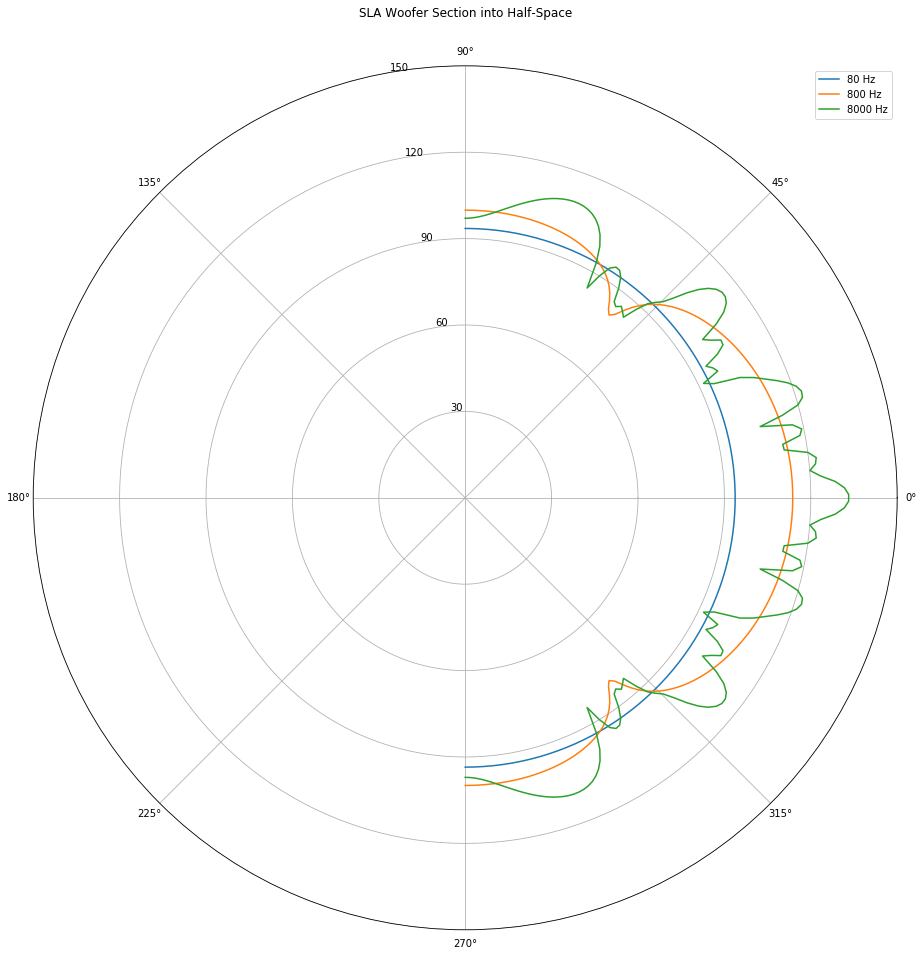

CPU times: user 620 ms, sys: 326 ms, total: 946 ms
Wall time: 50.8 s


In [13]:
%%time
solver = RayleighSolver3D(aVertex, aTriangle)
boundaryCondition = BoundaryCondition(solver.numberOfElements())
boundaryCondition.alpha.fill(0.0)
boundaryCondition.beta.fill(1.0)
boundaryCondition.f.fill(V)

aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(f, boundaryCondition) for f in aFrequency)

polarPlot("SLA Woofer Section into Half-Space", aFrequency, aMagnitudes)


CPU times: user 1.2 s, sys: 145 ms, total: 1.34 s
Wall time: 3h 1min 57s


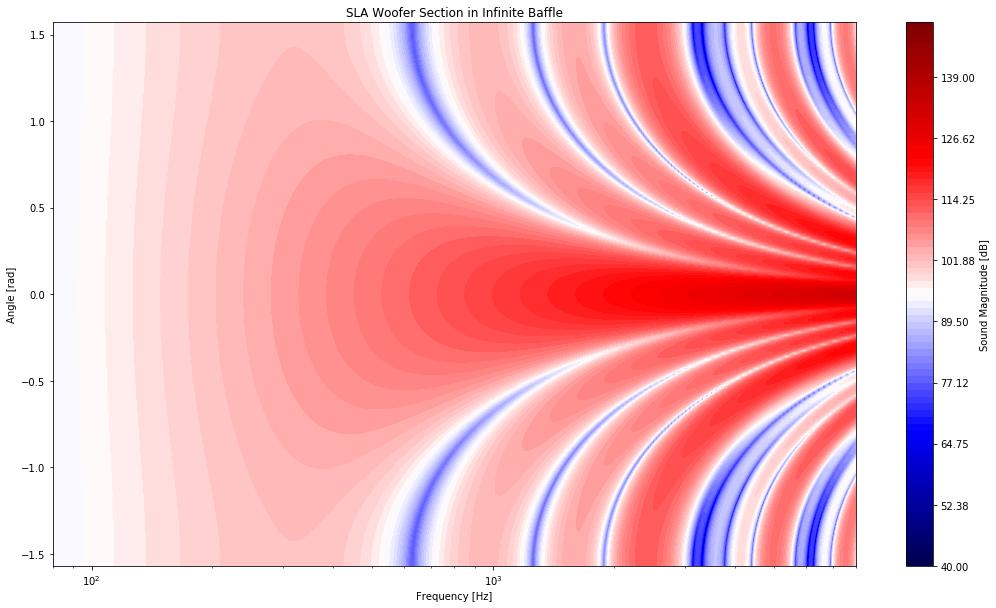

In [3]:
%%time
frequencySamples = 800
aFrequency = np.logspace(np.log10(80), np.log10(8000), frequencySamples)
angleSamples = 180
aSamples, _, aAngle = semiCircle(5, angleSamples, "yz")
aWavenumber = frequencyToWavenumber(aFrequency)

aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(f, boundaryCondition) for f in aFrequency)
aMagnitudes = np.asarray(aMagnitudes).transpose()

plotPolarMap('SLA Woofer Vertical Directivity', aFrequency, aAngle, aMagnitudes)


CPU times: user 1.2 s, sys: 133 ms, total: 1.33 s
Wall time: 3h 5min 18s


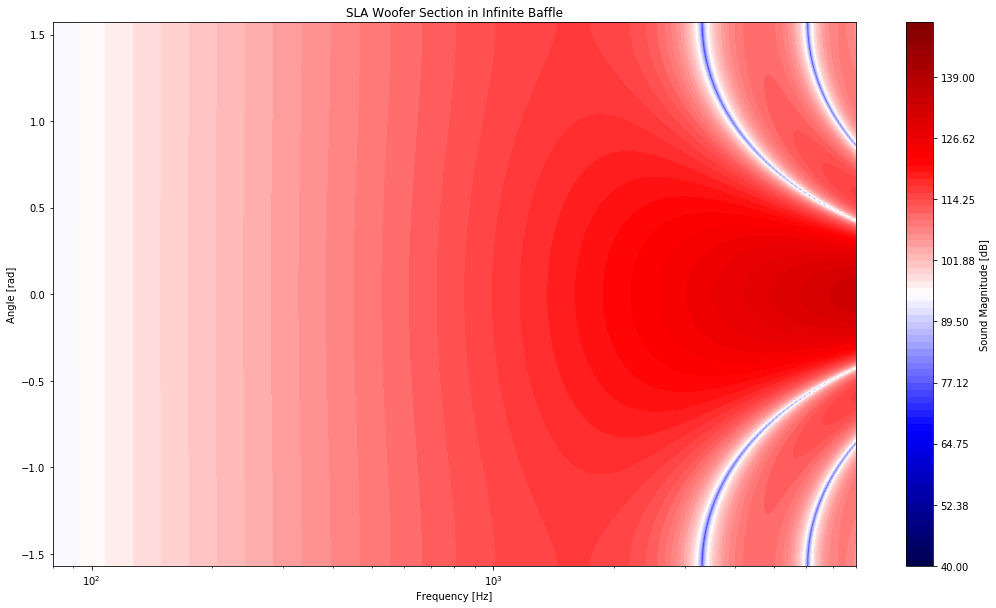

In [6]:
%%time
aSamples, _, aAngle = semiCircle(5, angleSamples, "xz")

aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(f, boundaryCondition) for f in aFrequency)
aMagnitudes = np.asarray(aMagnitudes).transpose()

plotPolarMap('SLA Woofer Horizontal Directivity', aFrequency, aAngle, aMagnitudes)


CPU times: user 850 ms, sys: 195 ms, total: 1.05 s
Wall time: 2h 51min 19s


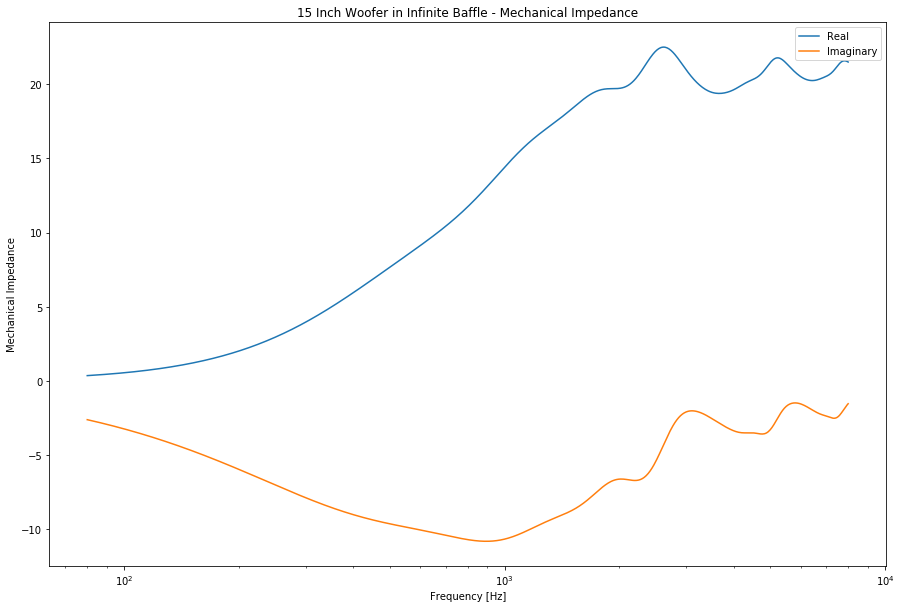

In [5]:
%%time
aNumericalZm = Parallel(n_jobs=4)(delayed(numericalZm)(k, boundaryCondition) for k in aWavenumber)
aNumericalZm = np.asarray(aNumericalZm)

fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title('15 Inch Woofer in Infinite Baffle - Mechanical Impedance')
ax.set_xlabel('Frequency [Hz]')
ax.set_xscale('log') 
ax.set_ylabel('Mechanical Impedance')
ax.plot(aFrequency, np.real(aNumericalZm), label='Real')
ax.plot(aFrequency, np.imag(aNumericalZm), label='Imaginary')
ax.legend()